# 内容提要

- 神经网络: 原理与实现
  - 从神经元到神经网络
  - 反向传播与模型训练
- 用`PyTorch`搭建并训练神经网络
  - 数据的处理
  - 模型的搭建
  - 模型的训练与评估
- 卷积神经网络(CNN): 归纳偏置(inductive bias)的应用
  - 卷积层
  - 池化层
  - LeNet模型
- 超参数优化
  - 回顾: 标准流程
  - 用`ray`管理超参数优化

$\quad$本次上机实习需要使用[`ray`](https://www.ray.io/)进行超参数优化, 需要先运行如下代码块先完成该库的[安装](https://docs.ray.io/en/latest/ray-overview/installation.html#from-wheels).

In [1]:
!pip install -U ipywidgets
!pip install -U "ray[data,train,tune,serve]"

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 1.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.9/214.9 kB 4.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.2
    Uninstalling widgetsnbextension-3.6.2:
      Successfully uninstalled widgetsnbextension-3.6.2
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.5
    Uninstalling jupyterlab-widgets-3.0.5:
      Successfully uninstalled jupyterlab-widgets-3.0.5
  Attempting uninstall: comm
    Found existing installation: comm 0.1.2
    Uninstalling comm-0.1.2:
      Successfully uninstalled comm-0.1.2
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.6.5
    Uninstalling ipywidgets-7.6.5:
      

In [2]:
import ray

# 神经网络: 原理与实现

$\quad$神经网络(neural networks)是**模型联结主义**(model connectionism)的典型例子, 将若干个**神经元**(neuron, 可以理解为最基本的决策单元)按照指定方式组合起来, 实现一个可训练的学习器, 用于学习**数据表示**(data representation).

$\quad$对于输入的特征$\mathbf{x}$, 机器学习总是试图找到一个(参数化的)非线性变换$\phi(\mathbf{x}; \mathbf{w})$, 或说表示(representation), 使得数据样本在变换后的新空间中的分布结构更有利于问题的解决. 例如: 分类问题希望在新的表示下, 分属不同类别的样本点之间存在清晰的决策平面. 为此,
- 传统统计学习模型多数采取“手工设计非线性变换”的策略;
- 以神经网络为基础的**深度学习**(deep learning)则选择了另一条道路: **从数据自身学习表示(或变换)**. 这将更少地依赖专家知识, 也更利于复杂问题的建模与预测; 但弊端也是显然的: 模型性能将高度依赖训练所用的数据.

## 从神经元到神经网络

$\quad$一个最基本的神经元对输入的特征$\mathbf{x}$依次进行如下两步的处理:
- 线性变换(或说, **仿射变换**, affine transformation):
  $$
  z = \mathbf{w}^\mathrm{T}\mathbf{x} + b;
  $$
- 非线性**激活函数**(activation function)的作用:
  $$
  a = h(z).
  $$

而将若干神经元组织成一层(layer)、将若干层组织成网络, 就得到一般意义下的**全连接神经网络**(fully-connected neural network, FCNN). 若将数据集写成矩阵$\mathbf{X} \in \mathbb{R}^{N \times M}$($N$为样本数, $M$为特征数), 则FCNN的表达式可以(递归地)写为

$$\begin{aligned}
\mathbf{H}^{(l)} &= h^{(l)}(\mathbf{H}^{(l-1)}\mathbf{W}^{(l)} + b^{(l)}), l = 1,\dots,L,\\
\mathbf{H}^{(0)} &\equiv \mathbf{X}.
\end{aligned}$$
其中, $L$代表神经网络的层数(也常称为**深度**), $h^{(l)}$为第$l$层的激活函数, $\mathbf{W}^{(l)} \in \mathbb{R}^{d_{l-1} \times d_l}, b^{(l)} \in \mathbb{R}$分别为第$l$层的**权重**(weights)与**偏置**(bias, 也就是截距). 这里我们将第$l$层的宽度记为$d_l$, 而$d_0 \equiv M$. 习惯上, $l=0$层称为输入层; $l=L$层称为输出层.

![alt image.png](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/d42378dabc704d52a9962cf1a4103494/16aNid5FU9LPCXyDrrpDPw.png)

$\quad$注意到, 神经网络的层与层之间总是以非线性的激活函数隔开, 这是相当必要的. (思考: 如果不增设非线性激活, 会导致什么问题?)

## 反向传播与模型训练

$\quad$当神经网络结构变得复杂时, 损失函数的梯度计算将十分繁琐😇, 从而使损失函数的数值优化变得困难. 所以, 我们需要考虑*自动化*的梯度计算流程, 这常称为**自动微分**(automatic differentiation, autodiff)技术. 现代深度学习框架大多采用**反向传播**(backward propagation, backprop)算法进行梯度计算. 以神经网络为例, 既然其表达式本质是复合函数, 我们将自然地应用链式法则.

- 深度学习是对算法库的灵活程度、模块化程度要求很高, 一般只提供模型搭建和训练所需的各种组件(或者“砌块”, building block), 以及一些经典文献中的模型. 诸如[`TensorFlow`](https://www.tensorflow.org/)、[`PyTorch`](https://pytorch.org/)等开源库往往习惯称为**深度学习框架**(deep learning frameworks).

$\quad$考虑损失函数$\mathcal{L} \equiv \mathcal{L}(\mathbf{H}^{(L)}, \mathbf{Y})$, 例如: MSE损失函数、交叉熵损失函数, 等等. 此时, 我们根据正向传播(也就是前述的变换表达式)的形式, 递归地考察$\mathcal{L}$关于权重$\mathbf{W}$的梯度. 书写计算过程时, 建议大家先按分量形式书写, 这样最清晰也最严格.

$$\begin{aligned}
\mathbf{H}^{(l)} &= h^{(l)}(\mathbf{H}^{(l-1)}\mathbf{W}^{(l)} + b^{(l)})\\
\Rightarrow \frac{\partial\mathcal{L}}{\partial\mathbf{W}_{ij}^{(l)}}
&= \sum_{i_1=1}^N{\sum_{j_1=1}^{d_l}{
\frac{\partial\mathcal{L}(\mathbf{H}^{(L)}, \mathbf{Y})}{\partial\mathbf{H}_{i_1j_1}^{(l)}}\sum_{i_2=1}^N{\sum_{j_2=1}^{d_l}{
\frac{\partial\mathbf{H}_{i_1j_1}^{(l)}}{\partial(\mathbf{H}^{(l-1)}\mathbf{W}^{(l)} + b^{(l)})_{i_2j_2}}\frac{\partial(\mathbf{H}^{(l-1)}\mathbf{W}^{(l)} + b^{(l)})_{i_2j_2}}{\partial\mathbf{W}_{ij}^{(l)}}
}}}}\\
&= \sum_{i_1=1}^N{\sum_{j_1=1}^{d_l}{
\Delta_{i_1j_1}^{(l)}\sum_{i_2=1}^N{\sum_{j_2=1}^{d_l}{
h'^{(l)}_{i_2j_2}\delta_{i_1i_2}\delta_{j_1j_2}\frac{\partial}{\partial\mathbf{W}_{ij}^{(l)}}\left(
\sum_{k=1}^{d_{l-1}}{\mathbf{H}_{i_2k}^{(l-1)}\mathbf{W}_{kj_2}^{(l)}}
\right)}}}}\\
&= \sum_{i_1=1}^N{\sum_{j_1=1}^{d_l}{
\Delta_{i_1j_1}^{(l)}h'^{(l)}_{i_1j_1}\sum_{k=1}^{d_{l-1}}{
\mathbf{H}_{i_1k}^{(l-1)}\delta_{ik}\delta_{jj_1}
}}}\\
&= \sum_{i_1=1}^N{
\Delta_{i_1j}^{(l)}h'^{(l)}_{i_1j}\mathbf{H}^{(l-1)}_{i_1i}
},
\end{aligned}$$
于是,
$$
\frac{\partial\mathcal{L}}{\partial\mathbf{W}^{(l)}} = (\mathbf{H}^{(l-1)})^\mathrm{T}(\Delta^{(l)} \odot h'^{(l)}),
$$
这就完成了梯度的递归表达式. 其中, $\Delta^{(L)} \equiv \frac{\partial \mathcal{L}}{\partial \mathbf{H}^{(L)}}$是可以直接计算的, 所以, 上述递推将从第$L$层逐步回到第1层. 这就是“反向传播”一词的由来.

$\quad$我们在这里顺便介绍一个矩阵微积分中的**小黑招**😍:
- 第1步: 先假设所有量都是标量, 按链式法则给出计算结果;
- 第2步: 想办法“凑”形状, 给出合理的运算顺序.

$$\begin{aligned}
\mathbf{H}^{(l)} &= h^{(l)}(\mathbf{H}^{(l-1)}\mathbf{W}^{(l)} + b^{(l)})\\
\Rightarrow \frac{\partial\mathcal{L}}{\partial\mathbf{W}^{(l)}}
&= \frac{\partial\mathcal{L}(\mathbf{H}^{(L)}, \mathbf{Y})}{\partial\mathbf{H}^{(l)}}
\cdot\frac{\partial\mathbf{H}^{(l)}}{\partial(\mathbf{H}^{(l-1)}\mathbf{W}^{(l)} + b^{(l)})}
\cdot\frac{\partial(\mathbf{H}^{(l-1)}\mathbf{W}^{(l)} + b^{(l)})}{\partial\mathbf{W}^{(l)}}\\
&= \Delta^{(l)} \cdot h'^{(l)} \cdot \mathbf{H}^{(l-1)}.
\end{aligned}$$

当我们将上述标量“还原”回矩阵时, 注意到 $\frac{\partial\mathcal{L}}{\partial\mathbf{W}^{(l)}} \in \mathbb{R}^{d_{l-1} \times d_l}, \Delta^{(l)} \in \mathbb{R}^{N \times d_l}, h'^{(l)} \in \mathbb{R}^{N \times d_l}, \mathbf{H}^{(l-1)} \in \mathbb{R}^{N \times d_{l-1}}$. 结合激活函数导数的原本含义, 以及这些形状, 我们不难给出下述的“拼凑”结果:

$$
\frac{\partial\mathcal{L}}{\partial\mathbf{H}^{(l)}} = (\mathbf{H}^{(l-1)})^\mathrm{T}(\Delta^{(l)} \odot h'^{(l)}).
$$

# 用`PyTorch`搭建并训练神经网络

$\quad$本节以MNIST(Modified National Institute of Standards and Technology database)数据集为例, 演示如何使用`PyTorch`进行神经网络模型工作流的搭建. 总体流程仍然包括: (1)处理数据, 使其能被接受为神经网络模型的输入; (2)搭建模型; (3)训练与评估. 只不过, 神经网络模型更加自由、模块化.

$\quad$MNIST数据集是用于[手写数字识别](http://yann.lecun.com/exdb/mnist/)的任务, 我们希望所训练的神经网络模型能够较好地根据手写数字图片预测其代表的是0~9这10个数字中的哪一个. 我们调用[`torchvision.datasets.MNIST`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#mnist)可以很方便地实现数据集的加载与下载.
- 训练集共有60000个样本, 测试集有10000个;
- 特征是28x28大小的灰度像素矩阵, 每个矩阵元都取0~255上的一个整数值, 数值越大代表颜色越黑(越深);
- 标签是0~9范围内的整数, 代表手写字迹对应的真实数字.

$\quad$我们构建一个10类别($c=10$)的SoftMax回归模型, 以一个两层的神经网络模型作为特征变换函数$f(\cdot)$, 并以负对数似然(NLL)作为损失函数. 即
$$\begin{aligned}
\mathbf{y} &= \mathrm{SoftMax}(f_{\boldsymbol{\theta}}(\mathbf{x})),\\
\mathcal{L}(\mathbf{t}, \mathbf{y}; \boldsymbol{\theta}) &= -\sum_{n=1}^N{\mathbf{t}^{(n)}\cdot\log{\mathbf{y}^{(n)}}},
\end{aligned}$$

并完成模型的训练与评估.


## 数据处理与可视化

$\quad$我们用[`torchvision`](https://pytorch.org/vision/0.9/)完成图像数据的预处理. 这是一个涵盖了常用的计算机视觉相关的(模型、数据、变换操作等元素的)深度学习库, 它将常见的图像变换处理操作(例如数据类型转换、特征归一化等等)封装在了[`torchvision.transforms`](https://pytorch.org/vision/0.9/transforms.html#torchvision-transforms)模块. 我们首先下载MNIST数据集, 并对数据集作如下一系列的变换:
- **数据类型转换**. 起初, 特征储存为[`PIL.Image.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image)格式, 我们用[`ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#totensor)将其转换为[`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html#torch-tensor)格式. 这是`PyTorch`用于数值计算的基本元素, 不论是数据还是模型参数都将表达为`Tensor`, 并用预先定义好的运算规则或算法实现数值操作, 例如前向计算、梯度(反向)计算、数值优化等.
- **特征归一化**. 这里, 我们以[`Normalize()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Normalize.html#normalize)进行均值-方差归一化操作. 我们将参数`mean`和`std`直接提供给大家: 分别为0.1307和0.3081.

以上两步变换可由[`Compose()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#compose)很方便地组装起来, 作为`transform`参数传入函数`MNIST()`.

In [3]:
import os
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
root_dir = os.getcwd()
transform = Compose([ToTensor(), Normalize((0.1307, ), (0.3081, ))])
train_dataset = MNIST(root=root_dir, train=True, download=True, transform=transform)
test_dataset = MNIST(root=root_dir, train=False, download=True, transform=transform)

$\quad$可以使用索引操作访问每个样本(但注意: *不支持切片!*), 索引将得到二元元组, 分别为特征和标签. 注意: 每个样本的特征`X0`的形状是1x28x28. 第一个维度是图片色彩的**通道**(channel). 由于MNIST图像都是灰度图, 所以只有1个通道; 而在RGB彩色图片中, 通道维度的大小就为3.

In [4]:
X0, y0_true = train_dataset[0]
X0.shape

torch.Size([1, 28, 28])

$\quad$我们取前20个训练样本进行可视化, 查看概况. 注意可视化函数中对`Tensor`做了[`squeeze()`](https://pytorch.org/docs/stable/generated/torch.squeeze.html#torch-squeeze)处理, 将(值为1的)通道维度“挤压”掉, 得到二维数组, 便于灰度图的绘制.

In [5]:
from typing import List
from matplotlib import pyplot as plt
def visualize_data(samples: List, n_rows: int):
    plt.figure(figsize=(10, 3))
    n_samples = len(samples)
    for i, sample in enumerate(samples):
        img, label = sample
        plt.subplot(n_rows, n_samples // n_rows, i + 1)
        plt.imshow(img.squeeze(), cmap="gray", interpolation="none")
        plt.title(f"label: {label}")
        plt.axis("off")
    plt.show()

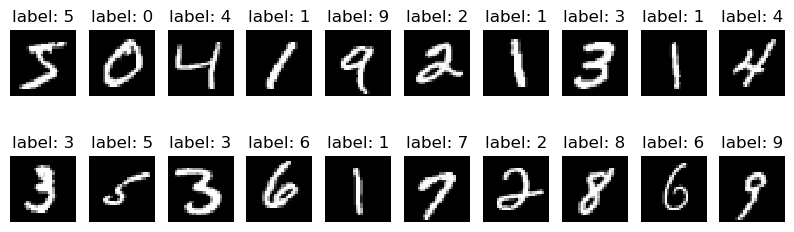

In [6]:
visualize_data(samples=list(train_dataset[i] for i in range(20)), n_rows=2)

## 神经网络模型的搭建

$\quad$如前所述, 深度学习框架往往只提供最基本的操作“砌块”, 需要由用户按照自己的设计将它们组装起来, 编写一个[`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#module)的子类作为模型模块. 在编写子类时, 至少需要实现如下两个方法:
- 初始化`__init__()`, 定义神经网络模型的层和相关的组件参数.
- 前向传播`forward`, 除了`self`外, 至少还需要一个参数: 输入数据`X`, 定义数据的前向计算过程.

`PyTorch`将在训练过程中根据`forward()`方法所定义的前向传播过程构建一张**计算图**(computational graph), 以[`backward()`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html#torch-tensor-backward)方法自动化地处理反向传播计算.

$\quad$我们先以一个`SoftMaxMLP`模型作为示例. 以下是模型架构的示意图:

![alt image.png](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/dea2dc5cd1344775983d68bdbbcd3b65/CVWlcOgo5a9p4jxkWe5Z4Q.png)


该模型的输入层接受28x28=784个特征(由于MLP的局限性, 我们不得不将二维图像“压扁”成一维向量作为输入), 输出层给出10个输出值, 经由SoftMax激活后解释为概率. 涉及到的计算组件包括:
- 线性操作层[`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#linear), 对数据施加线性变换;
- ReLU函数激活[`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#relu);
- 输出层的(对数-)SoftMax激活[`nn.functional.log_softmax`](https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html#torch-nn-functional-log-softmax). 这一方法在`PyTorch`中相比于SoftMax而言具有更好的数值稳定性, 与损失函数[`nn.NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#nllloss)是配合使用的.

这里, 每个组件都是一个对象, 实现前向传播时只需把它当成函数、直接调用即可(实质相当于调用`__call__`方法), 例如:
```python
linear = nn.Linear()
X_out = linear(X_in)
```

In [7]:
from torch import nn
from torch.nn import functional as F

class SoftMaxMLP(nn.Module):
    def __init__(self, num_inputs=784, num_hiddens=32, num_outputs=10):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hiddens)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(num_hiddens, num_outputs)
    def forward(self, X):
        # Note: the raw input data will be a 4-D tensor in shape (batch_size, num_channels, height, weight),
        # but the data applicable to SoftMaxMLP should be in shape (batch_size, num_features).
        # See the next subsection for detail.
        X = X.reshape(X.shape[0], -1)
        X = self.fc2(self.activation(self.fc1(X)))
        return F.log_softmax(X, dim=-1)

$\quad$我们对模型作简单的检查:
- 输出模型概况, 可以直接调用`print()`函数;
- 随便传入一个输入数据, 观察是否能成功完成前向传播.

In [8]:
softmax_mlp = SoftMaxMLP()
print(softmax_mlp)

SoftMaxMLP(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (activation): ReLU()
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


In [9]:
X = train_dataset[0][0].unsqueeze(0)
softmax_mlp(X)

tensor([[-2.2434, -1.8861, -2.4706, -2.6301, -2.1811, -2.5189, -2.3141, -2.3780,
         -2.0621, -2.6120]], grad_fn=<LogSoftmaxBackward0>)

## 模型的训练与评估

$\quad$根据给定的训练数据集$\mathcal{D}$, 我们就可以利用特定的数值优化算法$\mathcal{O}$对参数$\mathbf{W}$进行更新. 这些优化算法多数基于损失函数梯度, 即

$$
\mathbf{W}':=\mathcal{O}\left(\mathbf{W}, \nabla\mathcal{L}(\mathbf{W};\mathcal{D})\right).
$$

在模型训练过程中, 我们按特定的方式遍历训练数据, 并按顺序操作如下两个核心步骤:
- 根据前向传播的输出和真实标签计算损失函数$\mathcal{L}$;
- 利用反向传播方法计算梯度$\nabla\mathcal{L}$;
- 利用封装在[`torch.optim`](https://pytorch.org/docs/stable/optim.html#module-torch.optim)模块的特定**优化器**(optimizer)$\mathcal{O}$进行参数更新.

$\quad$如何遍历训练数据? 实践经验表明, 一个很高效的做法是将训练数据分作若干**批次**(batch), 并在每个批次上进行(平均)损失函数的计算与参数的更新. 基本理念是:**用少量数据上算出的、富于噪声的、程度更小的更新步, 代替全体数据上算出的、小噪声的、程度更大的更新步**.

- 批次划分的操作可以用[`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)很方便地完成, 我们用参数`batch_size`指定单批次的样本大小.
- 所获得的`DataLoader`对象本质是一个迭代器, 可以遍历各个数据批次, 每个数据批次的特征和标签都被“打包”成新的张量`Tensor`.
- 遍历`DataLoader`时, 每个批次的数据(“打包”的张量)都在第1个维度以左新增一个维度, 用以代指单条样本在该批次中的索引, 这是batch-first的数据组织格式, 为`PyTorch`所默认. 这不影响线性层`Linear`的操作, 因为矩阵乘法是对最末一个维度进行的.

In [10]:
from torch.utils.data import DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=1)

In [11]:
# inspect the first batch
first_batch_iter = iter(train_loader)
X_first_batch, y_true_first_batch = next(first_batch_iter)
X_first_batch.shape, y_true_first_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

$\quad$一般讲, 模型训练的基本流程可以用下述的代码块示意.
```python
for X, y_true in dataloader:
    y_output = model(X)
    loss = criterion(y_true, y_output)
    loss.backward()
    optimizer.step()
```
其中:
- `model`是我们创建好的神经网络模型, 可以直接像调用函数那样“调用”这一模型, 这等价于调用前向传播方法`forward()`.
- `criterion`是一个函数, 接收真实标签和前向传播的输出值, 计算损失函数, 结果以(标量)张量的形式存储在变量`loss`中.
- 作为可求梯度(即`requires_grad=True`)的`Tensor`, 我们对其调用`backward()`方法, 以反向传播完成梯度计算.
  - 完成反向传播操作后, 模型的所有**可训练参数**(作为张量)的梯度将保存在它们各自的`grad`属性中.
- `optimizer`是一个事先创建好的优化器对象. 在创建之初, 它就“获知”了模型的所有可训练参数(`model.parameters()`作为创建优化器时的首个形式参数), 并在每个更新步以[`step()`](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html#torch-optim-optimizer-step)方法根据梯度信息完成参数更新.

$\quad$我们定义函数`_train_softmax_mlp`, 以实现给定数据集上的训练, 同时返回训练集损失函数、验证集损失函数、验证集准确率accuracy. 为了使该函数能复用于后续的超参数优化过程, 我们将所有超参数打包成字典的形式, 作为参数`config`传入. 这里, 暂时不引入超参数优化, 所以以全体训练集作为训练数据, 全体测试集作为验证数据.

In [12]:
from typing import Dict, Tuple
import torch
from torch.optim import SGD
from torch.nn import NLLLoss
from tqdm import tqdm

def _train_softmax_mlp(
    train_dataset, val_dataset, config: Dict, num_epochs: int=5, log=True
) -> Tuple[List[float], List[float], List[float]]:
    # training setup
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"])
    val_loader = DataLoader(val_dataset)
    num_samples_train = len(train_dataset)
    num_samples_val = len(val_dataset)
    num_batches_train = len(train_loader)
    num_batches_val = len(val_loader)
    model = SoftMaxMLP(num_hiddens=config["num_hiddens"])
    optimizer = SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"])
    criterion = NLLLoss(reduction="mean")
    # train and evaluate the model
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    for epoch in tqdm(range(num_epochs)):
        # model training
        model.train()
        train_loss = 0
        for i, (X, y_true) in enumerate(train_loader):
            optimizer.zero_grad()
            y_prob = model(X)
            loss = criterion(y_prob, y_true)
            loss.backward()
            optimizer.step()
            train_loss += loss / num_batches_train
            if i % 400 == 0:
                if log:
                    print(f"Epoch: {epoch}; Batch No.: {i}, Loss: {loss.item()}")
        train_losses.append(train_loss.item())
        if log:
            print(f"Epoch: {epoch}, average loss = {train_loss.item()}")
        # model evaluation
        model.eval()
        train_acc, val_loss, val_acc = 0, 0, 0
        with torch.no_grad():
            for X, y_true in train_loader:
                y_prob = model(X)
                y_pred = torch.argmax(y_prob, dim=-1)
                train_acc += (y_true == y_pred).sum().item()
            train_accs.append(train_acc / num_samples_train)
            for X, y_true in val_loader:
                y_prob = model(X)
                val_loss += criterion(y_prob, y_true) / num_batches_val
                y_pred = torch.argmax(y_prob, dim=-1)
                val_acc += (y_true == y_pred).sum().item()
            val_losses.append(val_loss.item())
            val_accs.append(val_acc / num_samples_val)
    return train_losses, train_accs, val_losses, val_accs

In [13]:
SoftMaxMLP_config = {
    "num_hiddens": 32,
    "lr": 0.01,
    "momentum": 0.5,
    "batch_size": 32
}

train_losses, train_accs, val_losses, val_accs = _train_softmax_mlp(train_dataset, test_dataset, config=SoftMaxMLP_config, num_epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]Epoch: 0; Batch No.: 0, Loss: 2.307384729385376
Epoch: 0; Batch No.: 400, Loss: 0.3171120285987854
Epoch: 0; Batch No.: 800, Loss: 0.23380149900913239
Epoch: 0; Batch No.: 1200, Loss: 0.24243736267089844
Epoch: 0; Batch No.: 1600, Loss: 0.3874043822288513
Epoch: 0, average loss = 0.38004326820373535
 20%|██        | 1/5 [00:27<01:51, 27.96s/it]Epoch: 1; Batch No.: 0, Loss: 0.235903799533844
Epoch: 1; Batch No.: 400, Loss: 0.15013457834720612
Epoch: 1; Batch No.: 800, Loss: 0.1482381671667099
Epoch: 1; Batch No.: 1200, Loss: 0.21021553874015808
Epoch: 1; Batch No.: 1600, Loss: 0.22471484541893005
Epoch: 1, average loss = 0.21868394315242767
 40%|████      | 2/5 [00:55<01:23, 27.85s/it]Epoch: 2; Batch No.: 0, Loss: 0.13147501647472382
Epoch: 2; Batch No.: 400, Loss: 0.12639735639095306
Epoch: 2; Batch No.: 800, Loss: 0.12191960215568542
Epoch: 2; Batch No.: 1200, Loss: 0.19955013692378998
Epoch: 2; Batch No.: 1600, Loss: 0.18267695605754852
Epoch: 2, 

In [14]:
train_losses, train_accs, val_losses, val_accs

([0.38004326820373535,
  0.21868394315242767,
  0.17324422299861908,
  0.1467585414648056,
  0.12893350422382355],
 [0.9196333333333333,
  0.9423166666666667,
  0.9534333333333334,
  0.9598666666666666,
  0.9642333333333334],
 [0.2631591260433197,
  0.1978003978729248,
  0.16662293672561646,
  0.14831413328647614,
  0.1356779932975769],
 [0.9185, 0.9412, 0.9506, 0.9548, 0.9586])

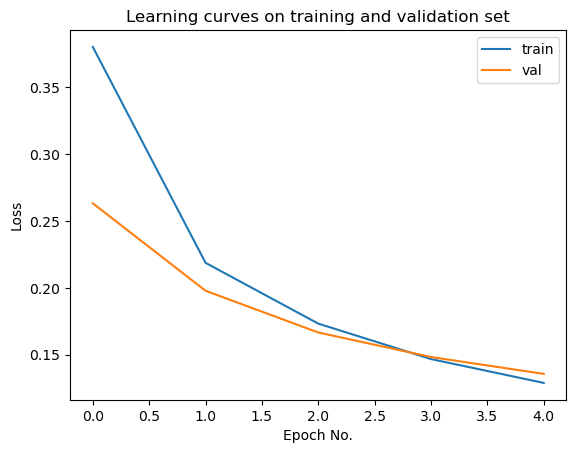

In [15]:
def plot_learning_curves(train_losses, val_losses):
    plt.title("Learning curves on training and validation set")
    plt.xlabel("Epoch No.")
    plt.ylabel("Loss")
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.legend()
    plt.show()

plot_learning_curves(train_losses, val_losses)

$\quad$训练与评估的代码较长, 我们再强调如下几个初学者常见的“陷阱”:
- 在开始训练前, 应先调用`model.train()`; 在结束训练、开始评估前, 应先调用`model.eval()`. 这是因为有些操作层(例如dropout、batch normalization等)在训练阶段与评估阶段将采取不同的操作.
- 在遍历数据批次时, 每次更新参数前都需要调用[`optimizer.zero_grad()`](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html#torch-optim-optimizer-zero-grad)方法, 将可训练参数的梯度清空(默认是设置为`None`, 有利于节约内存). 这是因为`PyTorch`的默认操作是在反向传播中将历次梯度的计算结果累积起来. 如果我们不希望是这样(这里就不希望如此), 就需要手动清空前一次的梯度计算结果.
- 模型评估的代码应在[`with torch.no_grad()`](https://pytorch.org/docs/stable/generated/torch.no_grad.html#no-grad)的作用域内编写. 此时, `PyTorch`将强制设置该作用域内的(几乎)所有`Tensor`的`requires_grad`属性为`False`, 前向传播计算不再触发计算图的构建. 这有利于节约内存.

# 卷积神经网络(CNN): 归纳偏置(inductive bias)的应用

$\quad$看起来, 我们已经取得了不错的预测效果😜! 不过, 图像毕竟是一种**结构化的数据**(structured data). 在许多更复杂的任务中,
- 直接“压扁”为一维向量输入MLP的做法并不能取得令人满意的效果, 因为这丢失了图像数据在空间上的结构信息.
- 如果训练数据量不够, 则纯粹的、不引入任何先验知识的MLP模型往往对有效信息的提取规律十分有限.

$\quad$现实世界的图像信息往往具有两条基本规律:
- **平移等变性**(translational equivariance): 相机镜头的平动会引起对应信息的同样程度的平动. 当图像输入$\mathbf{X}$的下标平移时, 对应的隐藏层表示也会发生相同的平移.
- **局域性**(locality): 对图像中的每个“元素”, 与之相关的信息不会离它很远. 隐藏层表示的某个分量只需包含进它附近的信息就足够了.

基于这两条假设, 我们就不必再对输入的图像$\mathbf{X} \in \mathbb{R}^{H \times W}$作一个(四维的)张量积运算
$$
\mathbf{H}_{i,j} = \sum_k{\sum_l{\mathsf{W}_{i,j,k,l}\mathbf{X}_{k,l}}},
$$
而是可以简化成一个**互相关**(cross-correlation)运算或**卷积**(convolution)运算:
$$
\mathbf{H}_{i,j} = \sum_{a = -\delta_a}^{\delta_a}{\sum_{b=-\delta_b}^{\delta_b}{\mathbf{V}_{a,b}\mathbf{X}_{i+a, j+b}}}.
$$

![alt image.png](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/d32858adbcbe4a2d83f0b8e350beb23c/ttk2YrdcvLBHX2fa2TuHxg.png)

## 卷积层

$\quad$(二维)卷积操作层在`PyTorch`中定义为[`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#conv2d).
- 它的输入数据是一个四维张量, 各个维度依次代表:
  - $N$, 批次大小(batch size).
  - $C_\mathrm{in}$, 输入数据的通道数. 卷积运算在各个通道上是独立进行的. 其中, 输入数据的通道数和输出数据的通道数分别由参数`in_channels`和`out_channels`指定.
  - $H$与$W$, 图片的高度(行数)和宽度(列数).
- 每个输入-输出通道对都对应一个**卷积核**(convolution kernel)$\mathbf{V}$, 其大小由参数`kernel_size`指定, 各个分量作为可训练参数用于模型训练.
- 还可以设置各种操作细节. 例如:
  - 图片边缘的**补零**(padding), 以充分提取原图片的边界信息. 补齐方式由参数`padding`指定, 默认为0(不补零).
  - 卷积核的滑动**步长**(striding), 以更快速地实现**降采样**(sub-sampling). 滑动步长由参数`stride`指定, 默认为1(每次移动1步).
  - 卷积核的**扩张**(dilation), 以使提取的信息更加广域, 扩张方式由参数`dilation`指定, 默认为1(不扩张卷积核, 相邻分量下标间距为1).

## 池化层

$\quad$池化(pooling)操作是一种具有局部平移不变性的降采样技术. 实践中一般推荐使用**最大池化**(maximum pooling). `PyTorch`的二维池化层定义为[`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#maxpool2d).
- 它的输入数据格式与卷积层的输入数据格式一致.
- 池化层不含任何可训练参数, “池化核”(或池化窗口)的大小由参数`kernel_size`指定.
- 它同样可以设置`padding`、`striding`和`dilation`等操作细节, 意义与卷积层的对应参数相同.

## LeNet模型
$\quad$Yann LeCun发展了基于卷积神经网络的手写数字识别模型[LeNet](https://ieeexplore.ieee.org/document/726791/), 其架构如下图所示:

![alt image.png](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/0fb23255d1f94a6681677cc9630dda2f/7yPMrEkxWeWJJwmVZf6LIQ.png)

我们给出对应的代码实现, 其中, 将平均池化(average pooling)替换为最大池化.

In [16]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.pooling1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pooling2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fcnn = nn.Sequential(
            nn.Linear(5 * 5 * 16, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
        )
    def forward(self, X):
        X = self.pooling1(torch.tanh(self.conv1(X)))
        X = self.pooling2(torch.tanh(self.conv2(X)))
        X = self.fcnn(X.reshape(X.shape[0], -1))
        return F.log_softmax(X, dim=-1)

In [17]:
lenet = LeNet5()
print(lenet)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pooling1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pooling2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fcnn): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [18]:
X = train_dataset[0][0].unsqueeze(0)
lenet(X)

tensor([[-2.3837, -2.2481, -2.3669, -2.2231, -2.1841, -2.3973, -2.3153, -2.3876,
         -2.1781, -2.3776]], grad_fn=<LogSoftmaxBackward0>)

$\quad$我们以相似的代码完成模型训练.

In [19]:
def _train_lenet(
    train_dataset, val_dataset, config: Dict, num_epochs: int=5, log=True
) -> Tuple[List[float], List[float], List[float]]:
    # training setup
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"])
    val_loader = DataLoader(val_dataset)
    num_samples_train = len(train_dataset)
    num_samples_val = len(val_dataset)
    num_batches_train = len(train_loader)
    num_batches_val = len(val_loader)
    model = LeNet5()
    optimizer = SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"])
    criterion = NLLLoss(reduction="mean")
    # train and evaluate the model
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    for epoch in tqdm(range(num_epochs)):
        # model training
        model.train()
        train_loss = 0
        for i, (X, y_true) in enumerate(train_loader):
            optimizer.zero_grad()
            y_prob = model(X)
            loss = criterion(y_prob, y_true)
            loss.backward()
            optimizer.step()
            train_loss += loss / num_batches_train
            if i % 400 == 0:
                if log:
                    print(f"Epoch: {epoch}; Batch No.: {i}, Loss: {loss.item()}")
        train_losses.append(train_loss.item())
        if log:
            print(f"Epoch: {epoch}, average loss = {train_loss.item()}")
        # model evaluation
        model.eval()
        train_acc, val_loss, val_acc = 0, 0, 0
        with torch.no_grad():
            for X, y_true in train_loader:
                y_prob = model(X)
                y_pred = torch.argmax(y_prob, dim=-1)
                train_acc += (y_true == y_pred).sum().item()
            train_accs.append(train_acc / num_samples_train)
            for X, y_true in val_loader:
                y_prob = model(X)
                val_loss += criterion(y_prob, y_true) / num_batches_val
                y_pred = torch.argmax(y_prob, dim=-1)
                val_acc += (y_true == y_pred).sum().item()
            val_losses.append(val_loss.item())
            val_accs.append(val_acc / num_samples_val)
    return train_losses, train_accs, val_losses, val_accs

In [20]:
LeNet5_config = {
    "lr": 0.01,
    "momentum": 0.5,
    "batch_size": 64
}

lenet_train_losses, lenet_train_accs, lenet_val_losses, lenet_val_accs = _train_lenet(
    train_dataset, test_dataset, config=LeNet5_config, num_epochs=5
)

  0%|          | 0/5 [00:00<?, ?it/s]Epoch: 0; Batch No.: 0, Loss: 2.314122200012207
Epoch: 0; Batch No.: 400, Loss: 0.7336716651916504
Epoch: 0; Batch No.: 800, Loss: 0.4980330169200897
Epoch: 0, average loss = 0.9297046065330505
 20%|██        | 1/5 [00:40<02:42, 40.62s/it]Epoch: 1; Batch No.: 0, Loss: 0.35707950592041016
Epoch: 1; Batch No.: 400, Loss: 0.24741485714912415
Epoch: 1; Batch No.: 800, Loss: 0.2745988667011261
Epoch: 1, average loss = 0.277768611907959
 40%|████      | 2/5 [01:20<02:01, 40.45s/it]Epoch: 2; Batch No.: 0, Loss: 0.19995161890983582
Epoch: 2; Batch No.: 400, Loss: 0.1478978544473648
Epoch: 2; Batch No.: 800, Loss: 0.2076907902956009
Epoch: 2, average loss = 0.1790487915277481
 60%|██████    | 3/5 [02:03<01:22, 41.32s/it]Epoch: 3; Batch No.: 0, Loss: 0.13293136656284332
Epoch: 3; Batch No.: 400, Loss: 0.10416807234287262
Epoch: 3; Batch No.: 800, Loss: 0.18103256821632385
Epoch: 3, average loss = 0.12769053876399994
 80%|████████  | 4/5 [02:44<00:41, 41.13s/i

In [21]:
lenet_train_losses, lenet_train_accs, lenet_val_losses, lenet_val_accs

([0.9297046065330505,
  0.277768611907959,
  0.1790487915277481,
  0.12769053876399994,
  0.10009458661079407],
 [0.90125,
  0.9378333333333333,
  0.95845,
  0.9688833333333333,
  0.9738833333333333],
 [0.3434719145298004,
  0.20625722408294678,
  0.1382017582654953,
  0.10159406810998917,
  0.08172232657670975],
 [0.9072, 0.9397, 0.9602, 0.9713, 0.9761])

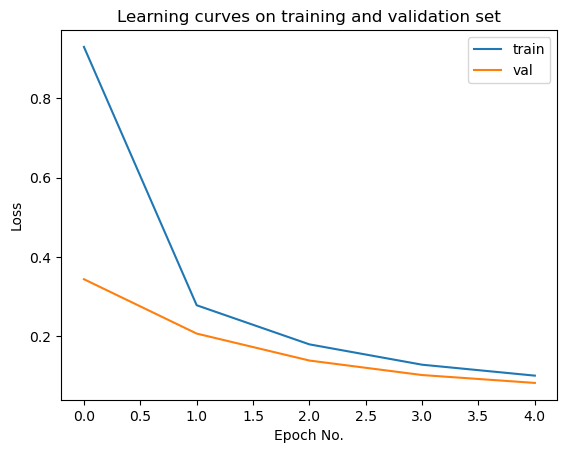

In [22]:
plot_learning_curves(lenet_train_losses, lenet_val_losses)

$\quad$可以看到, 在5轮次训练后, LeNet5在验证集(测试集)上的准确率比SoftMaxMLP模型高1%. 后者在深度学习研究项目中常称为**基线**(baseline)模型, 往往复杂度较低、预测性能不高, 我们希望所设计的新模型至少可以优于基线.

# 超参数优化

## 回顾: 标准流程

![alt image.png](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/0fb23255d1f94a6681677cc9630dda2f/W-blQI5JRsKUwffWgdyOZg.png)

$\quad$用伪代码表示如下.
```
metrics = []
for config in search_space:
    metrics.append(cross_validation(train_val_dataset, config))
best_config = argmax(metrics)
final_model = train(train_val_dataset, best_config)
```
其中, 交叉验证的过程`cross_validation`已经在上机实习2中介绍, 代码块展示如下. 这里采用10折交叉验证, 并返回验证集的平均损失函数、平均准确率.

- 注意: 我们的`cross_validation`函数接受的与数据集有关的参数是一个*被转换为列表的*k-fold生成器. 不能直接使用生成器(generator), 否则`ray`将出现“不可序列化”(not serializable)的报错信息.

In [23]:
def cross_validation(
    train_func, train_val_dataset, splits, config: Dict, num_epochs: int=5,
    log_train=False, log_cv=True
) -> Tuple[float, float]:
    val_losses, val_accs = [], []
    for fold, (train_idx, val_idx) in enumerate(splits):
        print(f"Fold No. {fold}...")
        train_set = list(train_val_dataset[i] for i in train_idx)
        val_set = list(train_val_dataset[i] for i in val_idx)
        val_loss, val_acc = train_func(train_set, val_set, config, num_epochs, log=log_train)[2:]
        val_losses.append(val_loss[-1])
        val_accs.append(val_acc[-1])
        if log_cv:
            print(f"...validation: loss {val_loss[-1]}, accuracy {val_acc[-1]}")
    loss = sum(val_losses) / len(val_losses)
    acc = sum(val_accs) / len(val_accs)
    return loss, acc

In [24]:
from sklearn.model_selection import KFold
splits = list(KFold(n_splits=5).split(train_dataset))
val_metrics = cross_validation(_train_lenet, train_dataset, splits, config=LeNet5_config, num_epochs=2)

Fold No. 0...
100%|██████████| 2/2 [00:29<00:00, 14.67s/it]
...validation: loss 0.2744824290275574, accuracy 0.92
Fold No. 1...
100%|██████████| 2/2 [00:29<00:00, 14.94s/it]
...validation: loss 0.27424702048301697, accuracy 0.92125
Fold No. 2...
100%|██████████| 2/2 [00:29<00:00, 14.85s/it]
...validation: loss 0.3066178858280182, accuracy 0.9093333333333333
Fold No. 3...
100%|██████████| 2/2 [00:30<00:00, 15.03s/it]
...validation: loss 0.290850967168808, accuracy 0.9144166666666667
Fold No. 4...
100%|██████████| 2/2 [00:29<00:00, 14.97s/it]...validation: loss 0.26667603850364685, accuracy 0.92325



In [25]:
val_metrics

(0.28257486820220945, 0.9176500000000001)

## 用`ray`管理超参数优化

$\quad$`ray`库可以很方便地帮助我们自动化地完成超参数搜索的工作流. 它的核心操作流程由[`ray.tune.Tuner`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.Tuner.html#ray.tune.Tuner)管理,
```python
tuner = tune.Tuner(trainable, tune_config, param_space)
results = tuner.fit()
```
其中:
- `trainable`是一个定义了模型创建与训练过程的函数, **要求只接受一个形参: `config`, 即超参数配置的字典**.
- `tune_config`定义了调参过程的必要工作参数, 例如采用的评估指标(例如accuracy)、取指标最小还是最大、调参的调度算法、所试验的超参数总组数等;
- `param_space`定义了超参数的搜索空间.

$\quad$可训练函数的接口要求与`_train_lenet`或`cross_validation`不符, 一个简单的小技巧是再写一个wrapper function, 此处命名为`train_lenet`, 用于实现5个训练周期条件下的5-折交叉验证. 这下终于理解`_train_lenet`函数名前加下划线的原因了吧! 😝
- 为了防止调参过程意外中断, 我们常可以设置若干**检查点**(checkpoint), 以便机器恢复正常后继续未尽的流程.

In [26]:
from ray import train
import os

def train_lenet(config):
    val_loss, val_acc = cross_validation(
        _train_lenet, train_dataset, splits, config, num_epochs=5,
        log_train=False, log_cv=False
    )
    train.report({"val_loss": val_loss, "val_acc": val_acc})

$\quad$工作参数被封装为[`tune.TuneConfig`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.TuneConfig.html#ray-tune-tuneconfig)进行管理. 以下述代码块为例, 我们规定超参数的“最优”定义为**使得验证集准确率的(交叉验证)平均值最高**. 同时,
- 约定取4组超参数作为候选组合(尝尝鲜即可! 它很耗时...);
- 采用[`ASHAScheduler`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.TuneConfig.html#ray-tune-tuneconfig)作为调度管理器. 这是一种常用于[大规模并行调参](https://arxiv.org/abs/1810.05934)的调度算法, 可以提早终止那些“希望不大”(表现差得离谱)的组合.

In [27]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler

# An ASHAScheduler with 8 epochs at most, and stops bad trials after 2 epochs
scheduler = ASHAScheduler(max_t=8, grace_period=2)

tune_config = tune.TuneConfig(
    metric="val_acc", mode="max",
    scheduler=scheduler,
    num_samples=4,
)

$\quad$超参数的搜索空间定义成一个字典的形式, 关键字为超参数名称, 值为`ray.tune`内置的一些采样器. 例如, 我们打算优化的超参数包括:
- 学习率`lr`, 在$10^{-4}\sim10^{-1}$的均匀对数空间内采样, 可使用[`tune.loguniform`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.loguniform.html#ray-tune-loguniform)函数.
- SGD算法的动量`momentum`(点击[这里](https://paperswithcode.com/method/sgd-with-momentum)可做直观的理解), 在0~1范围内均匀采样, 可使用[`tune.uniform`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.uniform.html#ray-tune-uniform)函数.
- 数据批次大小`batch_size`, 在4、8、16、32中随机选择, 可使用[`tune.choice`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.choice.html#ray-tune-choice)函数.

In [28]:
param_space = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "momentum": tune.uniform(0.0, 1.0),
    "batch_size": tune.choice([4, 8, 16, 32])
}

$\quad$现在, 我们将上述三个元素组装起来, 并进行正式的调参工作(时间会有些长...).
- 注意: 运行时将会出现内存过大的警告, 这是因为, 函数`train_lenet()`中, 将`train_dataset`这样体积较大的变量进行了(隐式的)复制. 实践中可以利用[`ray.put`](https://docs.ray.io/en/latest/ray-core/api/doc/ray.put.html#ray-put)和[`ray.get`](https://docs.ray.io/en/latest/ray-core/api/doc/ray.get.html#ray-get)实现**按引用传递**(pass by reference), 或者修改训练函数的架构、避免这种大规模复制, 从而节约内存.

```
Warning: The actor ImplicitFunc is very large (95 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
```

In [29]:
tuner = tune.Tuner(
    train_lenet,
    tune_config=tune_config,
    param_space=param_space
)
results = tuner.fit()

2023-11-12 14:54:23,611	WARNING worker.py:2074 -- Warning: The actor ImplicitFunc is very large (95 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(train_lenet pid=439) Fold No. 0...
100%|██████████| 5/5 [02:51<00:00, 34.32s/it]
(train_lenet pid=441) Fold No. 1... [repeated 4x across cluster]
100%|██████████| 5/5 [03:25<00:00, 41.13s/it]
(train_lenet pid=439) Fold No. 1...
100%|██████████| 5/5 [04:13<00:00, 50.61s/it]
(train_lenet pid=440) Fold No. 1...
100%|██████████| 5/5 [04:20<00:00, 52.19s/it]
(train_lenet pid=438) Fold No. 1...
100%|██████████| 5/5 [02:53<00:00, 34.78s/it]
(train_lenet pid=441) Fold No. 2...
100%|██████████| 5/5 [03:30<00:00, 42.04s/it]
(train_lenet pid=439) Fold No. 2...
100%|██████████| 5/5 [04:22<00:00, 52.57s/it]
(train_lenet pid=440) Fold No. 2...
100%|██████████| 5/5 [04:29<00:00, 53.81s/it]
(train_lenet pid=438) Fold No. 2...
100%|█████████

$\quad$调参结果以[`tune.ResultGrid`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.ResultGrid.html#ray.tune.ResultGrid)管理. 我们可以用[`get_best_result()`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.ResultGrid.get_best_result.html#ray.tune.ResultGrid.get_best_result)方法返回最优超参数的相关信息, 并以`.metrics`和`.config`属性分别访问指标值和对应配置.

In [30]:
best_result = results.get_best_result("val_acc", "max")
best_result.metrics, best_result.config

({'val_loss': 0.5208606958389282,
  'val_acc': 0.8651166666666666,
  'timestamp': 1699773378,
  'checkpoint_dir_name': None,
  'done': True,
  'training_iteration': 1,
  'trial_id': '4d7de_00000',
  'date': '2023-11-12_15-16-18',
  'time_this_iter_s': 1306.980213880539,
  'time_total_s': 1306.980213880539,
  'pid': 438,
  'hostname': 'bohrium-17993-1059089',
  'node_ip': '10.5.49.42',
  'config': {'lr': 0.00017127046201255295,
   'momentum': 0.5445272518067981,
   'batch_size': 8},
  'time_since_restore': 1306.980213880539,
  'iterations_since_restore': 1,
  'experiment_tag': '0_batch_size=8,lr=0.0002,momentum=0.5445'},
 {'lr': 0.00017127046201255295,
  'momentum': 0.5445272518067981,
  'batch_size': 8})

$\quad$带着这组最优超参数, 就可以正式在全部训练集上进行模型训练与测试啦!🥳 这很容易结合前面的代码内容给出对应实现, 我们省略这部分的代码了.